# Resonatpr Flux sweep

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from spirack import SPI_rack, S4g_module
from IPython.display import clear_output
from time import sleep

from qcodes.dataset import (
    Measurement,
    initialise_database,
    new_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.Keithley import Keithley2450


In [2]:
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
smu = Keithley2450('QRF_SMU','TCPIP0::192.168.0.101::inst0::INSTR')
vna.open()
twpa.open()
smu.reset()


Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04605745, firmware:1.7.12b) in 0.04s


In [3]:
with (run(vna)):
    mag, phase =  vna.get_data() 

In [4]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'fluxsweep'
params['qubit_name'] = 'S5_FRAN_2Q_res'
params['qubit_power'] = 0
params['vna_power'] = -55
params['center_freq'] = 7318655555.57 #Hz
params['twpa_power'] = -2.73
params['twpa_frequency'] = 7098.0
params['span_freq'] = 20
params['flux_curr'] = 0
params['temp'] = 15.3
params['comment'] = "Flux Att: 10dB @ 4 K + 3dB @ 10 K \n" +\
                    "# Drive Att: 52dB Total (30dB @ 20 mK)" +\
                    "# TWPA biased " +\
                    "# Connection Diagram: TII 2q 06-10-23" +\
                    "# Clean current source\n"

data_format = 'MA'
npoints = 1001

In [5]:
# Get low power pectrum
twpa.start_rf()
freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = 30, power = -55, sleep_t = 5, npoints = 1000, data_format = 'MA')
twpa.stop_rf()

#Caculate the quality factor
f_c, Qf,_ = Q(freqs,mag, True)

print('Center frequency: %2.2f Hz'%f_c)
print('Quality Factor: %2.3f'%Qf)
params['center_freq'] = f_c
#plt.plot(freqs*1e-9,mag)

<class 'Exception'>


ValueError: `ydata` must not be empty!

## Run a flux sweep with manual current control

In [7]:
# Setup the sweep parameters

initial_current = -0.5e-3
final_current = 0.5e-3
step_current = 0.001e-3

vna.set_sweep_npoints(npoints)
current_array = np.arange(initial_current,final_current,step_current)

#Intiialize SMU
smu.terminals("front")
smu.source.function("current")
smu.source.current(1E-6)  # Put 1uA through the resistor

delays = np.ndarray(len(current_array))
mags = np.ndarray((len(current_array),npoints))
phases = np.ndarray((len(current_array),npoints))
Z = np.ndarray((len(current_array),npoints),dtype=complex)

mags[:] = 0
phases[:] = 0
Z[:] = 0

vna.set_center_frequency(params['center_freq'])
vna.set_span_frequency(params['span_freq'])
vna.set_data_format('MA')
sleep(0.5)

freqs, mag, phase = meas_spectrum(vna, 
                                  f_c=params['center_freq']+2e6, 
                                  f_span = params['span_freq'], 
                                  power = params['vna_power'], 
                                  npoints=npoints,
                                  sleep_t = 0.1,
                                  avg_count = 30)

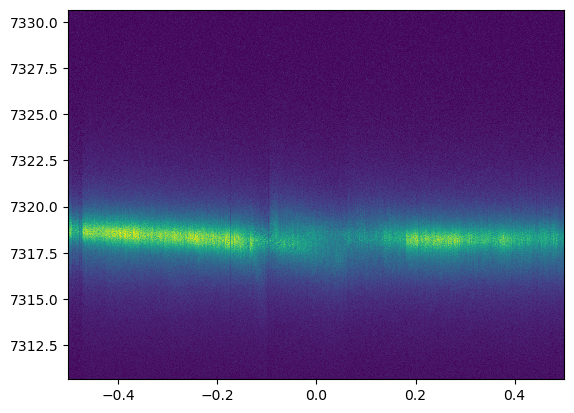

In [10]:
# run sweep

vna.start_rf()
twpa.start_rf()
sleep(1)

delay = 5
voltage = smu.sense.function("voltage")

try:
    for idx,curr in enumerate(current_array):   
        clear_output(wait=True)
    
        #Update Flux Current
        smu.source.current(curr)
        
        with (smu.output_enabled.set_to(True), run(vna)):
            voltage = smu.sense.voltage()
            sleep(delay)
            mag, phase =  vna.get_data()      
            
        mags[idx] = mag
        phases[idx] = phase    
    
        plt.pcolor(current_array*1e3,freqs*1e-6,mags.T)
        plt.show()
except:
    raise
    #print("Stopped")
finally:
    twpa.stop_rf()
    vna.stop_rf()
    smu.output_enabled.set_to(False)

Z = toComplex(mags,phases)

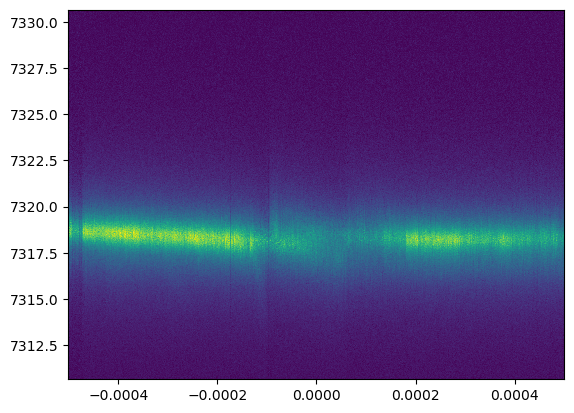

file saved as fluxsweep_S5_FRAN_2Q_res_20231110_1737


In [11]:
plt.pcolor(current_array,freqs*1e-6,mags.T)
plt.show()

header_str = get_plot_str(params)
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
np.savez("./data/"+filename,
         header = header_str,
         curr=current_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

In [12]:
twpa.stop_rf()
vna.stop_rf()
smu.output_enabled.set_to(False)